In [1]:
# !pip install fairlearn

In [2]:
import numpy as np
import warnings

warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder



from IPython.display import clear_output

np.random.seed(8)

In [3]:
data = pd.read_csv('onlinedeliverydata.csv')
data = data[["Age","Gender", "Marital Status","Occupation", "Monthly Income", "Educational Qualifications",
             "Family size","latitude", "longitude", "Pin code", "Output"]]
print(data.shape)
print(data.info())

(388, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         388 non-null    int64  
 1   Gender                      388 non-null    object 
 2   Marital Status              388 non-null    object 
 3   Occupation                  388 non-null    object 
 4   Monthly Income              388 non-null    object 
 5   Educational Qualifications  388 non-null    object 
 6   Family size                 388 non-null    int64  
 7   latitude                    388 non-null    float64
 8   longitude                   388 non-null    float64
 9   Pin code                    388 non-null    int64  
 10  Output                      388 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 33.5+ KB
None


### EDA

In [4]:
data.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes


In [5]:
le = LabelEncoder()
data['Output'] = le.fit_transform(data['Output'])
data.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,1
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,1
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,1
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,1
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,1


In [6]:
data['Output'].value_counts() # So baseline accuracy is be 301/(301+87) = 77.57%

Output
1    301
0     87
Name: count, dtype: int64

In [7]:
all_columns = data.columns
plt.figure(figsize=(6, 30))
for i, col in enumerate(all_columns):
    print("\n\n", data[col].value_counts())



 Age
23    73
22    57
25    52
24    50
26    35
21    23
27    21
32    16
28    15
29    14
20     9
30     9
31     8
19     4
18     1
33     1
Name: count, dtype: int64


 Gender
Male      222
Female    166
Name: count, dtype: int64


 Marital Status
Single               268
Married              108
Prefer not to say     12
Name: count, dtype: int64


 Occupation
Student           207
Employee          118
Self Employeed     54
House wife          9
Name: count, dtype: int64


 Monthly Income
No Income          187
25001 to 50000      69
More than 50000     62
10001 to 25000      45
Below Rs.10000      25
Name: count, dtype: int64


 Educational Qualifications
Graduate         177
Post Graduate    174
Ph.D              23
School            12
Uneducated         2
Name: count, dtype: int64


 Family size
3    117
2    101
4     63
5     54
6     29
1     24
Name: count, dtype: int64


 latitude
12.9770    36
12.9783    16
12.9850    14
12.8845    12
12.9369    11
           ..
1

<Figure size 600x3000 with 0 Axes>

In [8]:
drop_cols = ['Pin code']
numerical_cols = ['Age', 'latitude', 'longitude']

# Dropping Pin code due to it's functional dependency with latitude and longitude columns
data = data.drop(columns=drop_cols)
print(data.head())


for i in data.columns:
    print(i)
len(data.columns)

   Age  Gender Marital Status Occupation  Monthly Income  \
0   20  Female         Single    Student       No Income   
1   24  Female         Single    Student  Below Rs.10000   
2   22    Male         Single    Student  Below Rs.10000   
3   22  Female         Single    Student       No Income   
4   22    Male         Single    Student  Below Rs.10000   

  Educational Qualifications  Family size  latitude  longitude  Output  
0              Post Graduate            4   12.9766    77.5993       1  
1                   Graduate            3   12.9770    77.5773       1  
2              Post Graduate            3   12.9551    77.6593       1  
3                   Graduate            6   12.9473    77.5616       1  
4              Post Graduate            4   12.9850    77.5533       1  
Age
Gender
Marital Status
Occupation
Monthly Income
Educational Qualifications
Family size
latitude
longitude
Output


10

In [9]:
# Checking for null values
print((data.isnull().sum()!=0).sum())
data.describe()

0


,Age,Family size,latitude,longitude,Output
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,24.628866,3.280928,12.972058,77.600160,0.775773
std,2.975593,1.351025,0.044489,0.051354,0.417611
min,18.000000,1.000000,12.865200,77.484200,0.000000
25%,23.000000,2.000000,12.936900,77.565275,1.000000
50%,24.000000,3.000000,12.977000,77.592100,1.000000
75%,26.000000,4.000000,12.997025,77.630900,1.000000
max,33.000000,6.000000,13.102000,77.758200,1.000000


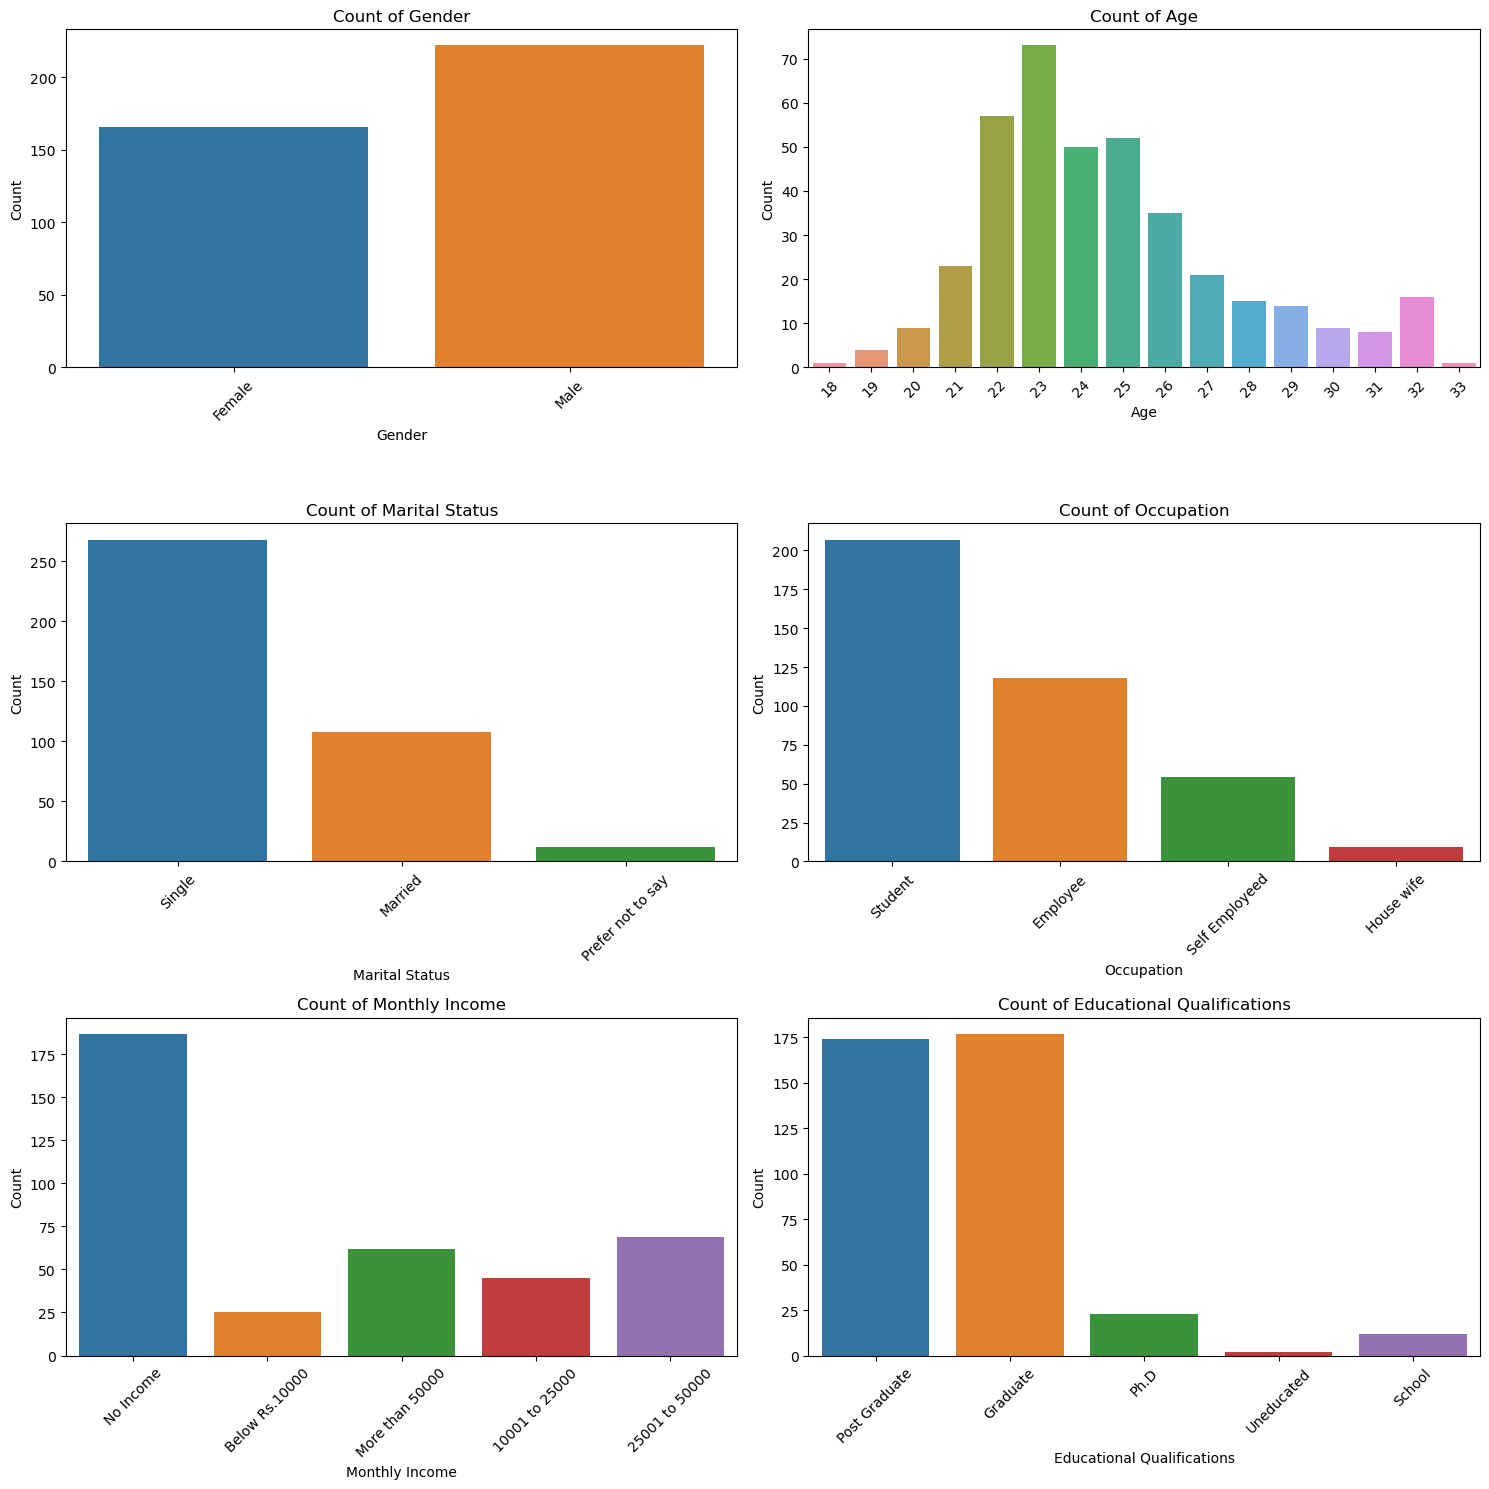

In [10]:
features_to_plot = ['Gender', 'Age', 'Marital Status',
                    'Occupation', 'Monthly Income',
                    'Educational Qualifications']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

for i, feature in enumerate(features_to_plot):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.countplot(data=data, x=feature, ax=ax)
    ax.set_title(f'Count of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Text(766.4999999999999, 0.5, 'Count')

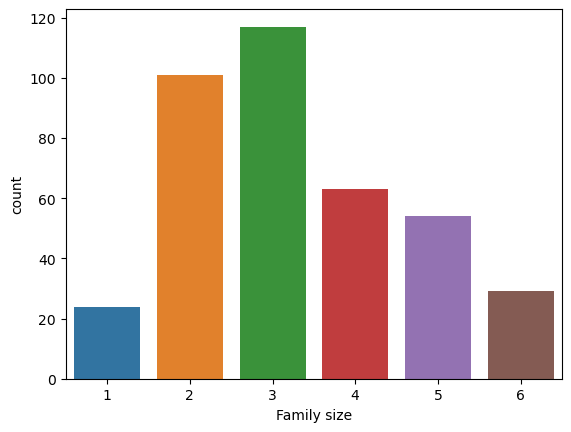

In [11]:
sns.countplot(data=data, x='Family size')
ax.set_title(f'Count of Family size')
ax.set_xlabel('Family size')
ax.set_ylabel('Count')

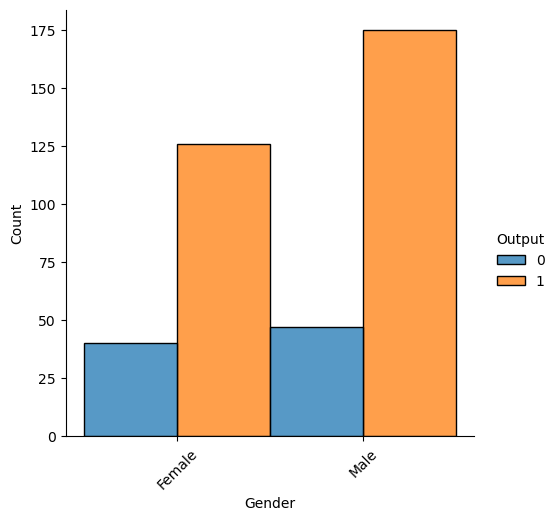

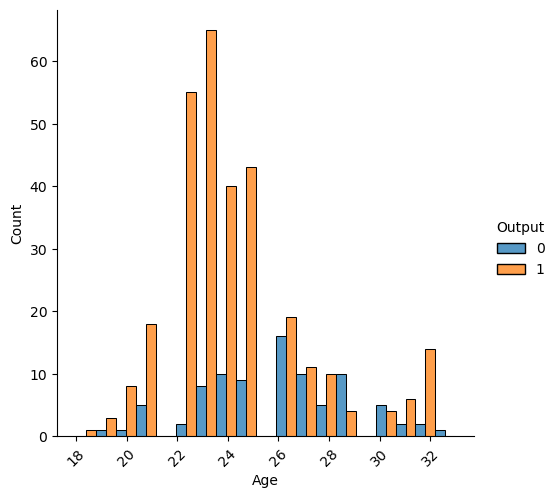

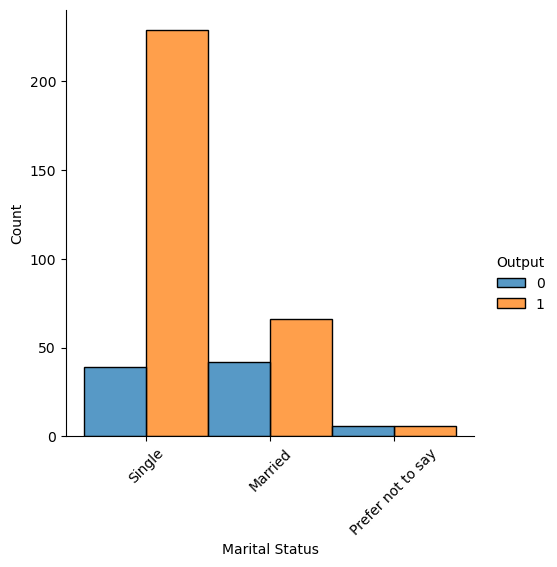

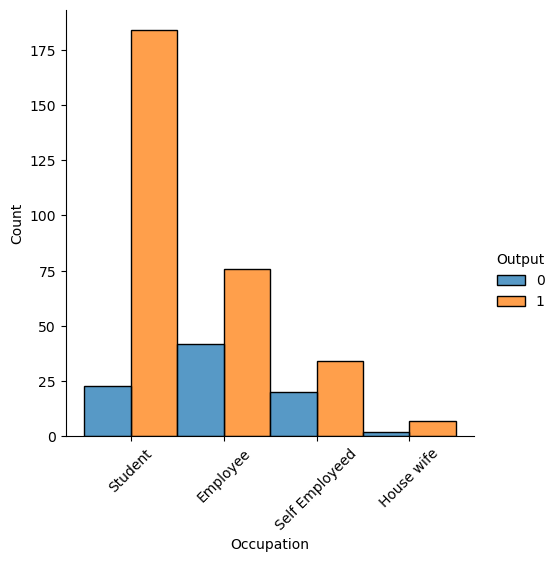

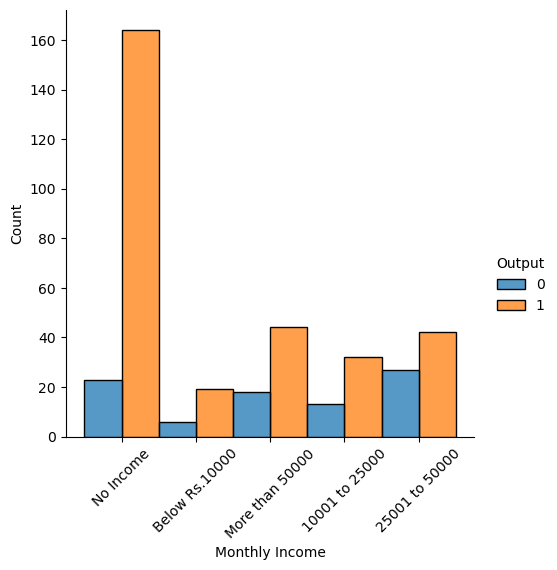

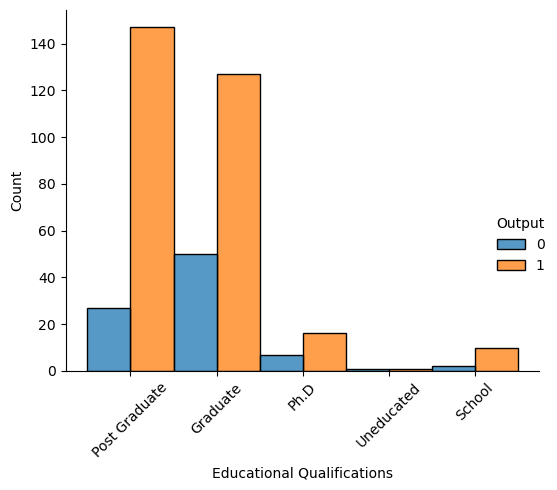

In [12]:
for i, feature in enumerate(features_to_plot):
    sns.displot(data=data, x=feature, hue='Output', multiple='dodge')
    plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [13]:
# On-hot encoding of categorical variables
data = pd.get_dummies(data)

In [14]:
data.columns

Index(['Age', 'Family size', 'latitude', 'longitude', 'Output',
       'Gender_Female', 'Gender_Male', 'Marital Status_Married',
       'Marital Status_Prefer not to say', 'Marital Status_Single',
       'Occupation_Employee', 'Occupation_House wife',
       'Occupation_Self Employeed', 'Occupation_Student',
       'Monthly Income_10001 to 25000', 'Monthly Income_25001 to 50000',
       'Monthly Income_Below Rs.10000', 'Monthly Income_More than 50000',
       'Monthly Income_No Income', 'Educational Qualifications_Graduate',
       'Educational Qualifications_Ph.D',
       'Educational Qualifications_Post Graduate',
       'Educational Qualifications_School',
       'Educational Qualifications_Uneducated'],
      dtype='object')

In [15]:
columns = ["Age", "Gender_Male", 'Marital Status_Single', 'Marital Status_Married', 'Occupation_Employee', "Occupation_Student", 'Occupation_Employee', 'Monthly Income_No Income',  'Monthly Income_10001 to 25000', 'Monthly Income_25001 to 50000', 'Monthly Income_Below Rs.10000', 'Educational Qualifications_Ph.D', 'Educational Qualifications_Post Graduate', 'Educational Qualifications_School', 'Educational Qualifications_Uneducated', 'longitude', 'latitude', 'Output']
corr_data = data[columns]

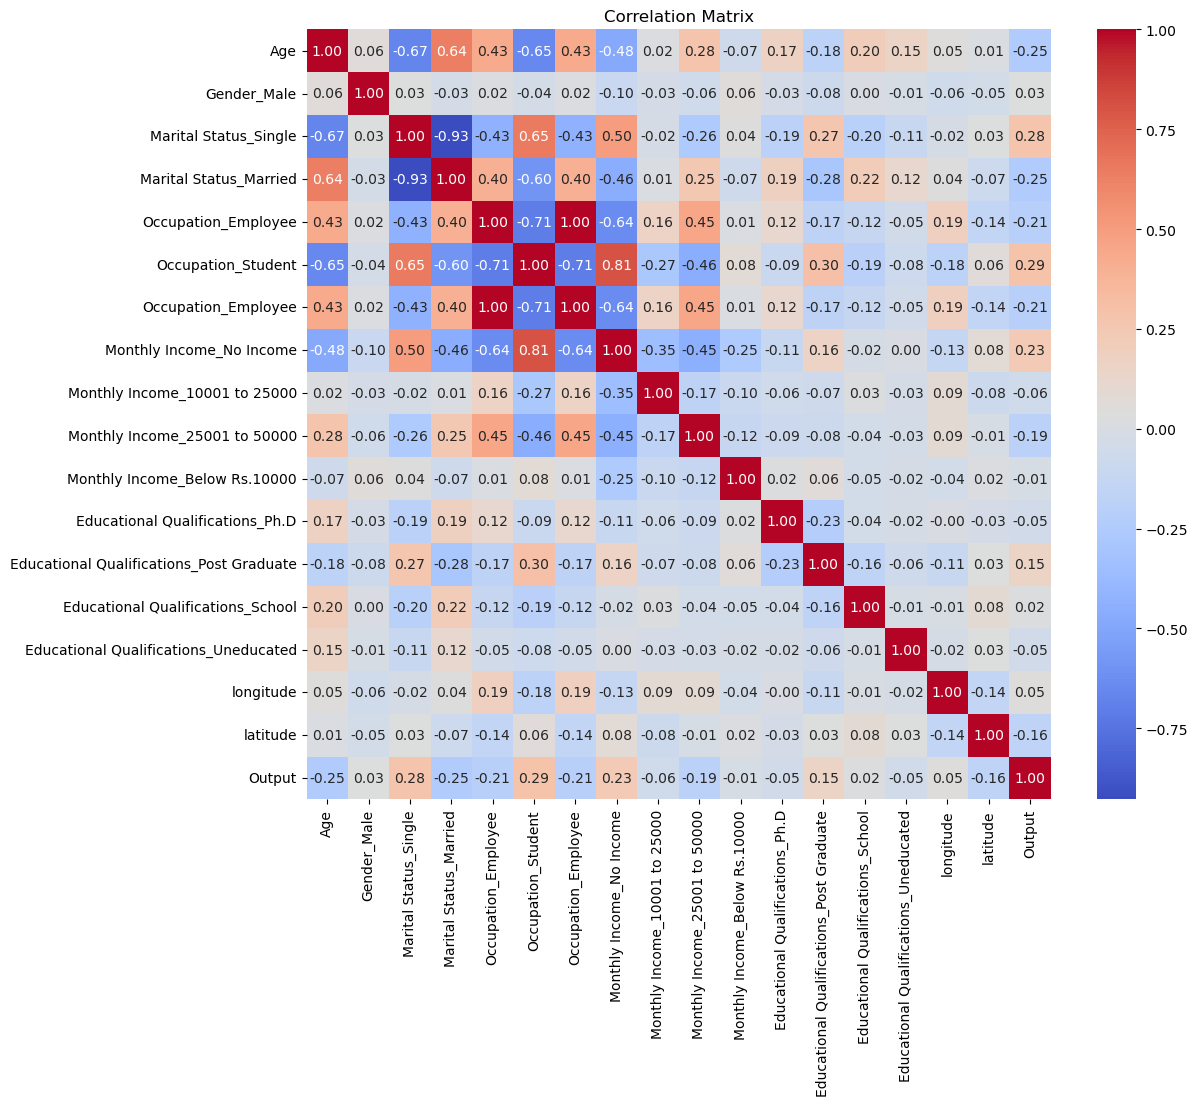

In [16]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

### Modeling

In [17]:
X = data.drop(['Output', 'Marital Status_Prefer not to say'], axis=1)
y = data['Output']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=101)

print("Shape of train dataset : ", X_train.shape)
print("Shape of test dataset : ", X_test.shape)

Shape of train dataset :  (271, 22)
Shape of test dataset :  (117, 22)


In [18]:
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train, y_train)

print(rfc.score(X_test, y_test))
y_train.value_counts()

0.8803418803418803


Output
1    211
0     60
Name: count, dtype: int64

In [19]:
# Hyperparameter tuning
max_depth = [3, 5, 7, 9, 12, 20]
n_estimators = [50, 100, 500, 1000, 2000]
min_samples_split = [5, 10]

rfc_model = RandomForestClassifier()
params = {"max_depth": max_depth, "n_estimators": n_estimators, 'min_samples_split':min_samples_split}

# accuracy
tuning = GridSearchCV(rfc_model, params, scoring='accuracy', verbose=1)
tuning.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9, 12, 20],
                         'min_samples_split': [5, 10],
                         'n_estimators': [50, 100, 500, 1000, 2000]},
             scoring='accuracy', verbose=1)

In [20]:
best_model = tuning.best_estimator_
print(tuning.best_params_)

{'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 50}


In [21]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.30      0.42        27
           1       0.82      0.97      0.89        90

    accuracy                           0.81       117
   macro avg       0.77      0.63      0.65       117
weighted avg       0.80      0.81      0.78       117

0.811965811965812
[[ 8 19]
 [ 3 87]]


## Fairness Audit

In [22]:
from fairlearn.metrics import *

### Gender

In [23]:
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['Gender_Male'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['Gender_Male'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for males and females
male_selection_rate = selection_rate(y_test[X_test['Gender_Male']==1], y_pred[X_test['Gender_Male']==1])
female_selection_rate = selection_rate(y_test[X_test['Gender_Male']==0], y_pred[X_test['Gender_Male']==0])

print(f'Male selection rate: {male_selection_rate:.4f}')
print(f'Female selection rate: {female_selection_rate:.4f}')

Demographic parity difference: 0.0879
Demographic parity ratio: 0.9067
Male selection rate: 0.9420
Female selection rate: 0.8542


In [24]:
print(equalized_odds_difference(y_test,
                               y_pred,
                               sensitive_features= X_test['Gender_Male']))

0.38888888888888895


In [25]:
sensitive_feature_sex = X_test['Gender_Male'].replace({1:'male', 0:'female'})

#evaluation metrics
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate, 
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

In [26]:
grouped_on_sex.overall

accuracy          0.811966
selection_rate    0.905983
FNR               0.033333
FPR               0.703704
dtype: float64

In [27]:
grouped_on_sex.by_group

,accuracy,selection_rate,FNR,FPR
Gender_Male,,,,
False,0.875000,0.854167,0.051282,0.444444
True,0.768116,0.942029,0.019608,0.833333


<Axes: title={'center': 'Accuracy and selection rate by sex'}, xlabel='Gender_Male'>

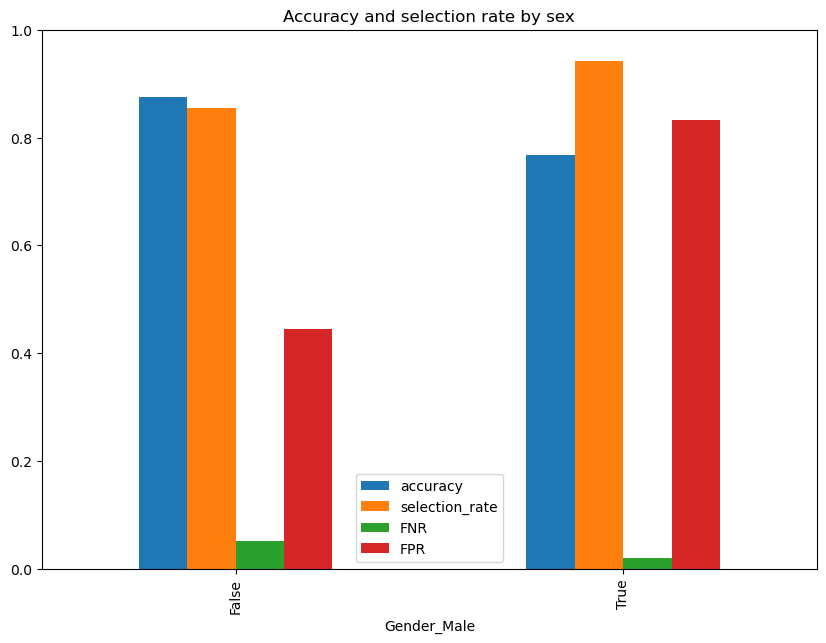

In [28]:
grouped_on_sex.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by sex",
    )

### Marital Status

In [29]:
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['Marital Status_Single'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['Marital Status_Single'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for singles and married
single_selection_rate = selection_rate(y_test[X_test['Marital Status_Single']==1], y_pred[X_test['Marital Status_Single']==1])
married_selection_rate = selection_rate(y_test[X_test['Marital Status_Single']==0], y_pred[X_test['Marital Status_Single']==0])

print(f'Single selection rate: {single_selection_rate:.4f}')
print(f'Married selection rate: {married_selection_rate:.4f}')

Demographic parity difference: 0.1920
Demographic parity ratio: 0.8007
Single selection rate: 0.9634
Married selection rate: 0.7714


In [30]:
print(equalized_odds_difference(y_test,
                               y_pred,
                               sensitive_features= X_test['Marital Status_Single']))

0.1428571428571429


In [31]:
sensitive_feature_maritalstatus = X_test['Marital Status_Single']

#evaluation metrics
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,  
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_maritalstatus = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                        sensitive_features=sensitive_feature_maritalstatus)

In [32]:
grouped_on_maritalstatus.by_group

,accuracy,selection_rate,FNR,FPR
Marital Status_Single,,,,
False,0.657143,0.771429,0.142857,0.642857
True,0.878049,0.963415,0.000000,0.769231


<Axes: title={'center': 'Accuracy and selection rate by marital status'}, xlabel='Marital Status_Single'>

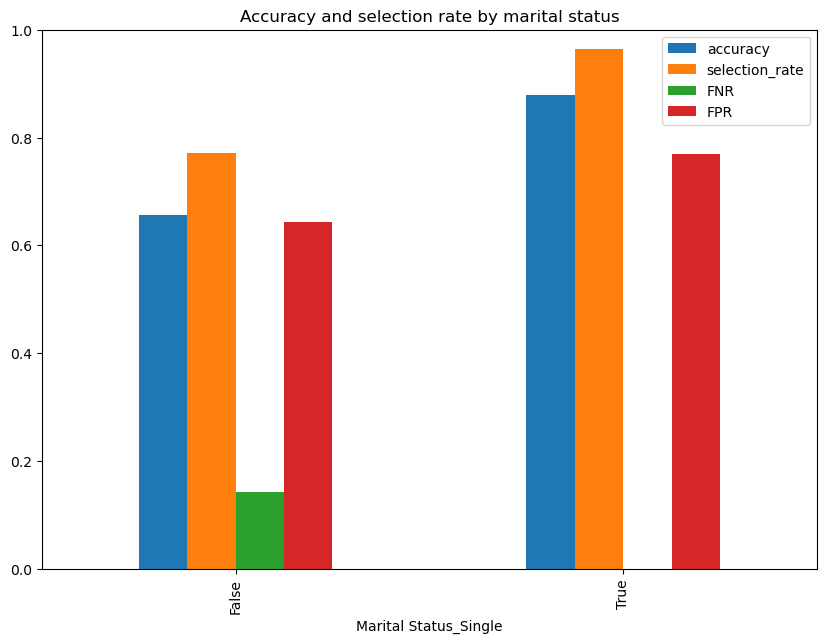

In [33]:
grouped_on_maritalstatus.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by marital status",
    )

### Monthly Income

In [34]:
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['Monthly Income_No Income'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['Monthly Income_No Income'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for singles and married
noIncome_selection_rate = selection_rate(y_test[X_test['Monthly Income_No Income']==1], y_pred[X_test['Monthly Income_No Income']==1])
Income_selection_rate = selection_rate(y_test[X_test['Monthly Income_No Income']==0], y_pred[X_test['Monthly Income_No Income']==0])

print(f'No Income selection rate: {noIncome_selection_rate:.4f}')
print(f'Income selection rate: {Income_selection_rate:.4f}')

Demographic parity difference: 0.1213
Demographic parity ratio: 0.8745
No Income selection rate: 0.9661
Income selection rate: 0.8448


In [35]:
print(equalized_odds_difference(y_test,
                               y_pred,
                               sensitive_features= X_test['Monthly Income_No Income']))

0.11111111111111116


In [36]:
sensitive_feature_MonthlyIncome = X_test['Monthly Income_No Income']

#evaluation metrics
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,  
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_MonthlyIncome = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_MonthlyIncome)

In [37]:
grouped_on_MonthlyIncome.by_group

,accuracy,selection_rate,FNR,FPR
Monthly Income_No Income,,,,
False,0.741379,0.844828,0.075,0.666667
True,0.881356,0.966102,0.000,0.777778


<Axes: title={'center': 'Accuracy and selection rate by marital status'}, xlabel='Monthly Income_No Income'>

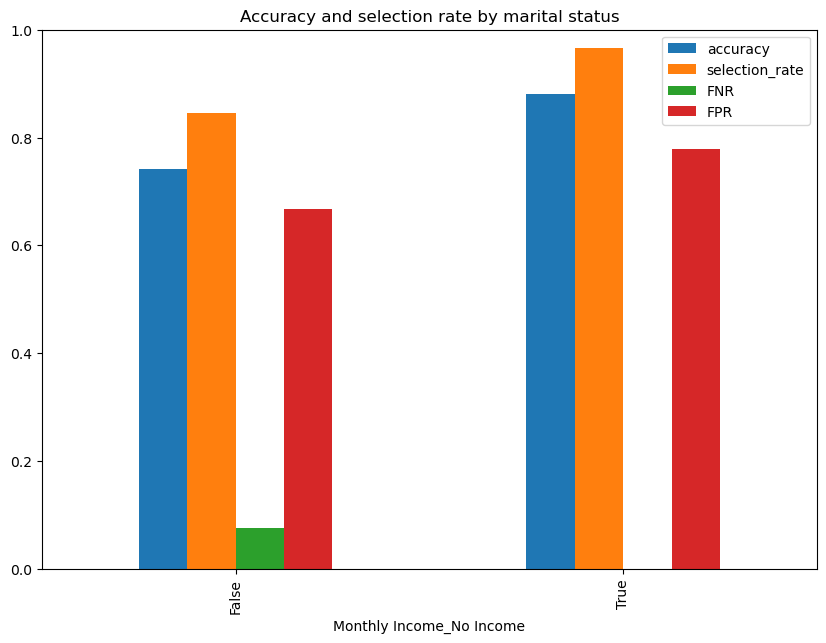

In [38]:
grouped_on_MonthlyIncome.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by marital status",
    )

-------------------

## SHAP

In [39]:
import shap

In [40]:
incorrectly_classified = np.where(y_pred != y_test)[0]
correctly_classified = np.where(y_pred == y_test)[0]

In [41]:
# Analyzing model's confidence in misclassified examples
predicted_probabilities = best_model.predict_proba(X_test)
confidence = np.abs(predicted_probabilities[:, 0] - predicted_probabilities[:, 1])

In [42]:
confidence_misclassified = confidence[incorrectly_classified]
len(confidence_misclassified)

22

Text(0, 0.5, 'Frequency')

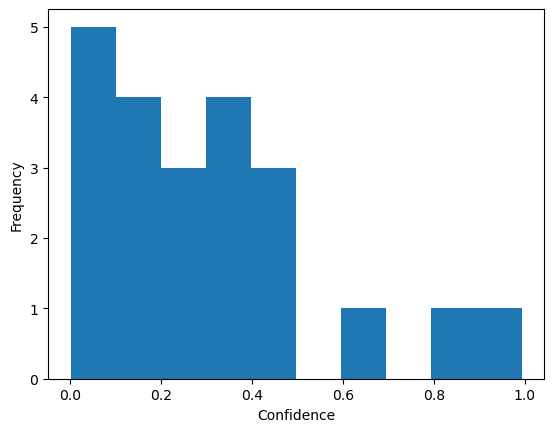

In [43]:
plt.hist(confidence_misclassified)
plt.xlabel('Confidence')
plt.ylabel('Frequency')

In [44]:
# Initialize the explainer
explainer = shap.TreeExplainer(best_model)
# Compute shap values
shap_values = explainer.shap_values(X_test)


In [45]:
print(explainer.expected_value, explainer.expected_value.shape)
shap_values.shape

[0.21933579 0.78066421] (2,)


(117, 22, 2)

In [46]:
shap_values[3].shape

(22, 2)

In [47]:
y_test.values[3]

0

In [48]:
idx = incorrectly_classified[0]
print('Predicted:', y_pred[idx], 'Ground Truth:', y_test.values[idx])
print(X_test.iloc[idx]['Gender_Female'], X_test.iloc[idx]['Marital Status_Single'])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[idx, :, 1], X_test.columns)


Predicted: 1 Ground Truth: 0
False False


In [49]:
idx = incorrectly_classified[1]
print('Predicted:', y_pred[idx], 'Ground Truth:', y_test.values[idx])
print(X_test.iloc[idx]['Gender_Male'], X_test.iloc[idx]['Occupation_Student'])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[idx, :, 1], X_test.columns)

Predicted: 1 Ground Truth: 0
True False


In [50]:
idx = incorrectly_classified[2]
print('Predicted:', y_pred[idx], 'Ground Truth:', y_test.values[idx])
print(X_test.iloc[idx]['Marital Status_Single'], X_test.iloc[idx]['Family size'])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[idx, :, 1], X_test.columns)

Predicted: 1 Ground Truth: 0
True 2


In [51]:
idx = correctly_classified[0]
print('Predicted:', y_pred[idx], 'Ground Truth:', y_test.values[idx])
print(X_test.iloc[idx]['Gender_Male'], X_test.iloc[idx]['Occupation_Student'])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[idx, :, 1], X_test.columns)

Predicted: 1 Ground Truth: 1
False True


Understanding Global feature importance

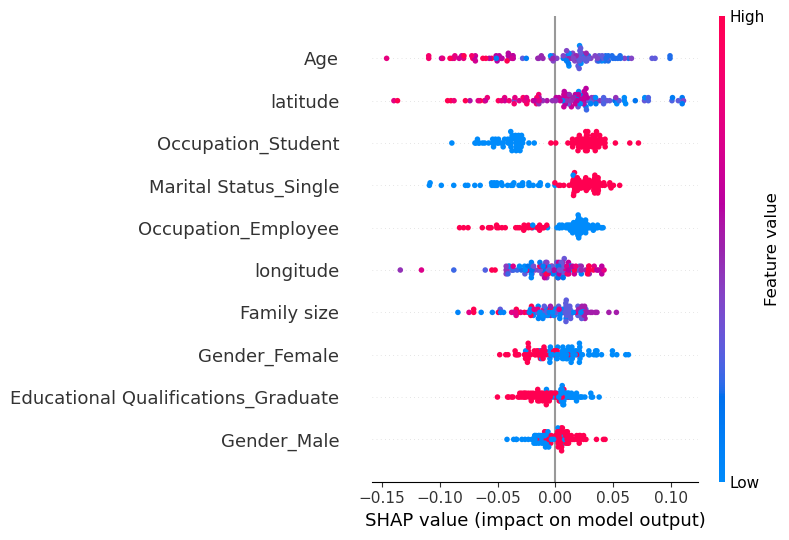

In [52]:
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X_test.columns, max_display=10)

Comparing if the feature importances have the same summary

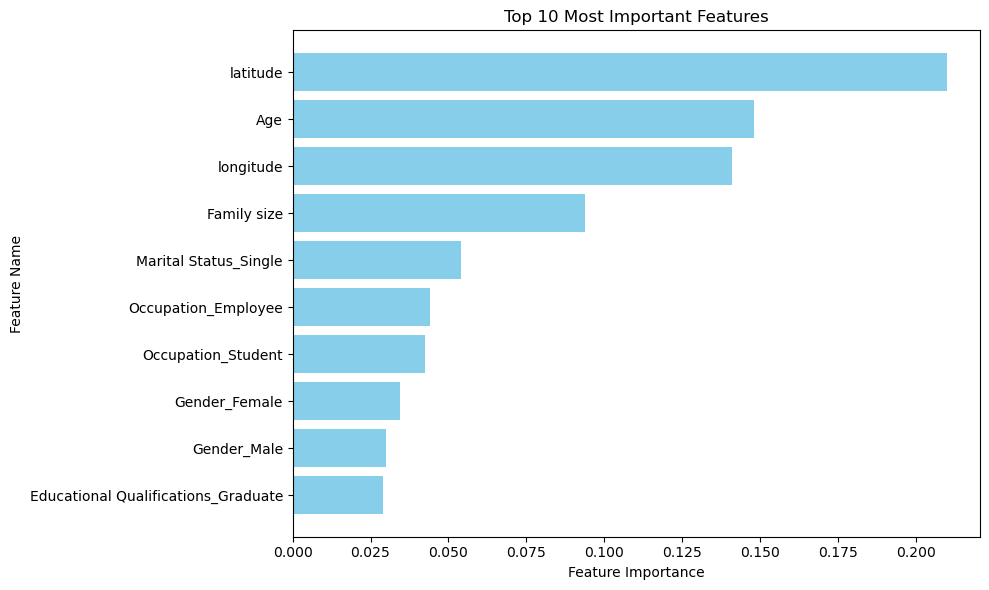

In [53]:
feature_importances = best_model.feature_importances_


df_feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
df_sorted = df_feature_importance.sort_values(by='importance', ascending=False)  # Sort by importance descending

top_10_features = df_sorted.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['feature'], top_10_features['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Misclassfication confidence and feature analysis with an attempt to improve the model

In [54]:
incorrect_feature_count = {}
incorrect_feature_weight = {}

for idx in incorrectly_classified:
    for feature_idx, shap_val in enumerate(shap_values[idx, :, 1]):
      if ((y_test.values[idx] == 1) and (shap_val < 0)) or ((y_test.values[idx] == 0) and (shap_val >0)):
        if feature_idx not in incorrect_feature_count.keys():
          incorrect_feature_count[feature_idx] = 1
          incorrect_feature_weight[feature_idx] = abs(shap_val)
        else:
          incorrect_feature_count[feature_idx] += 1
          incorrect_feature_weight[feature_idx] += abs(shap_val)

Text(0, 0.5, 'Number of features')

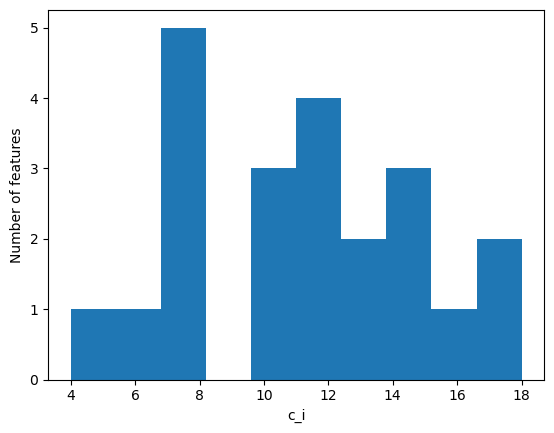

In [55]:
plt.hist(incorrect_feature_count.values())
plt.xlabel('c_i')
plt.ylabel('Number of features')

Text(0, 0.5, 'Number of features')

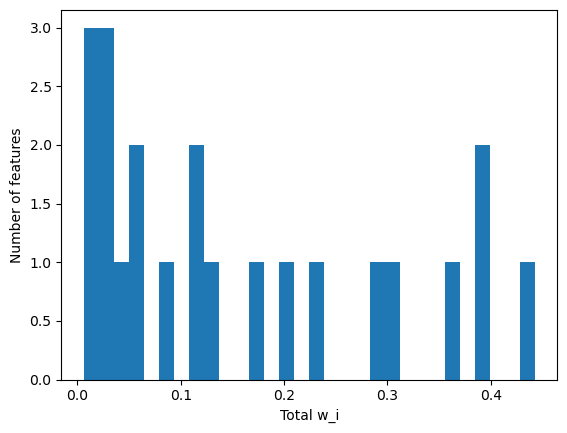

In [56]:
plt.hist(incorrect_feature_weight.values(), bins=30)
plt.xlabel('Total w_i')
plt.ylabel('Number of features')

In [57]:
features_to_remove = []
for feature in incorrect_feature_count:
  if (incorrect_feature_count[feature] > 17) or (incorrect_feature_weight[feature] > 0.35):
    features_to_remove.append(feature)

features_to_keep = []
for i in range(X_train.shape[1]):
  if i not in features_to_remove:
    features_to_keep.append(i)

X_train_improved = X_train.iloc[:, features_to_keep]
X_test_improved = X_test.iloc[:, features_to_keep]


In [58]:
len(features_to_remove)

6

In [59]:
max_depth = [3, 5, 7, 9, 12, 20]
n_estimators = [50, 100, 500, 1000, 2000]
min_samples_split = [5, 10]

rfc_model = RandomForestClassifier()
params = {"max_depth": max_depth, "n_estimators": n_estimators, 'min_samples_split':min_samples_split}

# accuracy
tuning_improved = GridSearchCV(rfc_model, params, scoring='accuracy', verbose=1)
tuning_improved.fit(X_train_improved, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9, 12, 20],
                         'min_samples_split': [5, 10],
                         'n_estimators': [50, 100, 500, 1000, 2000]},
             scoring='accuracy', verbose=1)

In [60]:
best_model_improved = tuning_improved.best_estimator_
print(tuning_improved.best_params_)

{'max_depth': 9, 'min_samples_split': 5, 'n_estimators': 50}


In [61]:
y_pred_improved = best_model_improved.predict(X_test_improved)
print(classification_report(y_test, y_pred_improved))
print(accuracy_score(y_test, y_pred_improved))
print(confusion_matrix(y_test, y_pred_improved))

              precision    recall  f1-score   support

           0       0.82      0.33      0.47        27
           1       0.83      0.98      0.90        90

    accuracy                           0.83       117
   macro avg       0.82      0.66      0.69       117
weighted avg       0.83      0.83      0.80       117

0.8290598290598291
[[ 9 18]
 [ 2 88]]
